In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from datetime import datetime 

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from tensorflow.keras.models import Sequential, load_model
import tensorflow as tf

# stops this program from hogging the GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

2023-05-25 17:21:45.422828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-25 17:21:45.422841: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-25 17:21:46.219660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 17:21:46.219892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-25 17:21:46.219971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [3]:
df = pd.read_feather('../../../jmarchezi/research-projects/solar-wind-data-with-gaps/outputData/combined_ace_data_resampled.feather')

In [4]:
pd.to_datetime(df['ACEepoch'], format='%Y-%m-%d %H:%M:%S')
df.set_index('ACEepoch', inplace=True, drop=True)
df.index = pd.to_datetime(df.index)

df.dropna(inplace=True)
df.drop(['YR', 'Month', 'Day', 'HR'], axis=1, inplace=True)

In [5]:
time_diff = df.index.to_series().diff()
mask = (time_diff.shift(-1) == pd.Timedelta(minutes=1)) & (time_diff == pd.Timedelta(minutes=1))

print(mask.sum())

# Find consecutive True values in the mask
consecutive_true = mask.cumsum()
mask = mask & (consecutive_true % 2 == 1)

print(mask.sum())

num_true = mask.sum()
max_samples = int(len(df) * 0.2)  # 20% of the total number of rows

# If the number of True values exceeds the maximum samples, randomly sample from the True indices
if num_true > max_samples:
    sample_indices = mask[mask].sample(n=max_samples, random_state=42).index
    mask = mask.index.isin(sample_indices)

samples_to_nan = df[mask]

6278314
3139157


In [6]:
test_vx_nans = df['Vx'].copy()
test_vx_nans.loc[test_vx_nans.index.isin(samples_to_nan.index)] = np.nan
print(df)

                      B_Total    BY_GSM    BZ_GSM          Vx         Vy  \
ACEepoch                                                                   
1998-02-05 00:01:00 -0.105875 -1.512952  3.543102  325.715881  -2.561846   
1998-02-05 00:02:00 -0.093000 -1.552128  3.600013  324.736481  -3.829421   
1998-02-05 00:03:00 -0.090600 -1.555936  3.604502  325.696991   0.044271   
1998-02-05 00:04:00 -0.054967 -1.649037  3.725267  324.035065  -2.356790   
1998-02-05 00:05:00 -0.005875 -1.757239  3.846891  324.898804  -3.771827   
...                       ...       ...       ...         ...        ...   
2020-12-31 23:54:00  2.602933 -2.728904  0.691111  362.555084   6.700056   
2020-12-31 23:55:00  1.932750 -2.164211  1.474539  359.486938  12.246122   
2020-12-31 23:56:00  2.018750 -2.247712  1.453048  358.852631   9.111342   
2020-12-31 23:57:00  2.189700 -2.424797  1.485945  360.278900   7.429704   
2020-12-31 23:58:00  2.224233 -2.451070  1.427514  361.805573  11.947581   

           

In [7]:
# Check for consecutive rows with NaN values
consecutive_nan = test_vx_nans.isnull() & test_vx_nans.shift().isnull()

# Check if any consecutive NaN rows exist
if consecutive_nan.any():
    print("Consecutive NaN rows exist.")
else:
    print("No consecutive NaN rows.")

No consecutive NaN rows.


In [8]:
linear_interp = test_vx_nans.interpolate(method='linear')
test_vx = pd.DataFrame({'real':df['Vx'].copy(),
						'nans':test_vx_nans,
						'linear_interp':linear_interp})

In [9]:
test_vx = test_vx.loc[test_vx.index.isin(samples_to_nan.index)]
test_vx

,real,nans,linear_interp
ACEepoch,,,
1998-02-05 00:02:00,324.736481,NaN,325.706436
1998-02-05 00:04:00,324.035065,NaN,325.297897
1998-02-05 00:12:00,325.348480,NaN,324.538986
1998-02-05 00:20:00,325.238068,NaN,323.909851
1998-02-05 00:24:00,324.817078,NaN,324.063187
...,...,...,...
2020-12-31 23:43:00,367.367767,NaN,363.984268
2020-12-31 23:45:00,364.496674,NaN,365.725250
2020-12-31 23:47:00,366.163208,NaN,365.292984


In [10]:
training_data = df[~df.index.isin(samples_to_nan.index)]
testing_data = df[df.index.isin(samples_to_nan.index)]


In [11]:
X_train = np.array(training_data.drop('Vx', axis=1).reset_index(drop=True, inplace=False))
y_train = np.array(training_data['Vx'].reset_index(drop=True, inplace=False))
X_test = np.array(testing_data.drop('Vx', axis=1).reset_index(drop=True, inplace=False))
y_test = np.array(testing_data['Vx'].reset_index(drop=True, inplace=False))

In [12]:
'''Model training and predicting section. These will be the SK learn based models such as linear regression, tree-based models, etc.'''

'Model training and predicting section. These will be the SK learn based models such as linear regression, tree-based models, etc.'

In [12]:
# First is linear regression
linear_reg = LinearRegression().fit(X_train, y_train)
LR_test = linear_reg.predict(X_test)
test_vx['linear_regression'] = LR_test

In [13]:
# Next is K-Nearest Neighbors. Here will do a single one and an ensamble
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
knn_test = knn.predict(X_test)
test_vx['knn'] = knn_test

In [14]:
# the knn ensamble where we change the number of neighbors
knn2 = KNeighborsRegressor(n_neighbors=2, weights='distance')
knn2.fit(X_train, y_train)
knn2_test = knn2.predict(X_test)

knn4 = KNeighborsRegressor(n_neighbors=4, weights='distance')
knn4.fit(X_train, y_train)
knn4_test = knn4.predict(X_test)

knn6 = KNeighborsRegressor(n_neighbors=6, weights='distance')
knn6.fit(X_train, y_train)
knn6_test = knn6.predict(X_test)

knn8 = KNeighborsRegressor(n_neighbors=8, weights='distance')
knn8.fit(X_train, y_train)
knn8_test = knn8.predict(X_test)

knn10 = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn10.fit(X_train, y_train)
knn10_test = knn10.predict(X_test)

knn_ensamble = np.mean([knn2_test, knn4_test, knn6_test, knn8_test, knn10_test], axis=0)

test_vx['knn_ensamble'] = knn_ensamble

KeyboardInterrupt: 

In [ ]:
# Next is Decision Tree. Here will do a single one and an ensamble
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
tree_test = tree.predict(X_test)
test_vx['tree'] = tree_test

In [ ]:
# the decision tree ensamble where we change the random state
tree0 = DecisionTreeRegressor(random_state=1)
tree0.fit(X_train, y_train)
tree0_test = tree0.predict(X_test)

tree1 = DecisionTreeRegressor(random_state=10)
tree1.fit(X_train, y_train)
tree1_test = tree1.predict(X_test)

tree2 = DecisionTreeRegressor(random_state=100)
tree2.fit(X_train, y_train)
tree2_test = tree2.predict(X_test)

tree3 = DecisionTreeRegressor(random_state=1000)
tree3.fit(X_train, y_train)
tree3_test = tree3.predict(X_test)

tree4 = DecisionTreeRegressor(random_state=10000)
tree4.fit(X_train, y_train)
tree4_test = tree4.predict(X_test)

tree_ensamble = np.mean([tree0_test, tree1_test, tree2_test, tree3_test, tree4_test], axis=0)

test_vx['tree_ensamble'] = tree_ensamble

In [ ]:
test_vx

,real,nans,linear_interp,linear_regression,knn,knn_ensamble,tree,tree_ensamble
ACEepoch,,,,,,,,
1998-02-05 00:02:00,324.736481,NaN,325.706436,284.322373,364.889369,369.495290,324.361694,324.361694
1998-02-05 00:04:00,324.035065,NaN,325.297897,285.079070,392.536870,392.988403,324.736053,324.784198
1998-02-05 00:12:00,325.348480,NaN,324.538986,285.637767,334.748991,336.107363,324.898804,324.977295
1998-02-05 00:20:00,325.238068,NaN,323.909851,296.273183,353.702597,353.107348,325.686005,325.692596
1998-02-05 00:24:00,324.817078,NaN,324.063187,288.176294,326.204701,326.198997,324.817078,324.817078
...,...,...,...,...,...,...,...,...
2020-12-31 23:43:00,367.367767,NaN,363.984268,399.777625,352.384126,354.746760,367.675171,367.489484
2020-12-31 23:45:00,364.496674,NaN,365.725250,397.264309,364.258571,365.385245,364.516479,364.500464
2020-12-31 23:47:00,366.163208,NaN,365.292984,399.747640,368.229340,369.911220,366.163208,366.163208


In [15]:
# Random Forest time. Here will do a single one and an ensamble
forest = RandomForestRegressor(verbose=1, n_estimators=100, random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)
forest_test = forest.predict(X_test)
test_vx['forest'] = forest_test

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.


KeyboardInterrupt: 

In [14]:
ann_xtrain, ann_xval, ann_ytrain, ann_yval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(ann_xtrain)
ann_xtrain = scaler.transform(ann_xtrain)
ann_xval = scaler.transform(ann_xval)
ann_xtest = scaler.transform(X_test)

In [15]:
model = Sequential()						# initalizing the model

model.add(Dense(100, activation='relu', input_shape=(ann_xtrain.shape[1],)))		# Adding dense layers with dropout in between
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)		# learning rate that actually started producing good results
model.compile(optimizer=opt, loss='mse')					# Ive read that cross entropy is good for this type of model
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)		# early stop process prevents overfitting

model.fit(ann_xtrain, ann_ytrain, validation_data=(ann_xval, ann_yval),
					verbose=1, shuffle=True, epochs=500, callbacks=[early_stop], batch_size=1024)

ann_test = model.predict(ann_xtest)

test_vx['ANN'] = ann_test

Epoch 1/500
4372/4372 [==============================] - 12s 3ms/step - loss: 21437.0820 - val_loss: 1227.2278
Epoch 2/500
4372/4372 [==============================] - 11s 3ms/step - loss: 12676.3984 - val_loss: 1170.4385
Epoch 3/500
4372/4372 [==============================] - 11s 3ms/step - loss: 12040.2480 - val_loss: 768.9024
Epoch 4/500
4372/4372 [==============================] - 11s 3ms/step - loss: 11606.6123 - val_loss: 925.4953
Epoch 5/500
4372/4372 [==============================] - 11s 3ms/step - loss: 11151.6025 - val_loss: 760.6027
Epoch 6/500
3952/4372 [==========================>...] - ETA: 1s - loss: 10731.9541

KeyboardInterrupt: 

In [ ]:
# # the random forest ensamble where we change the random state and the number of estimators
# forest0 = RandomForestRegressor(verbose=1, n_estimators=10, random_state=1)
# forest0.fit(X_train, y_train)
# forest0_test = forest0.predict(X_test)

# forest1 = RandomForestRegressor(verbose=1, n_estimators=50, random_state=10)
# forest1.fit(X_train, y_train)
# forest1_test = forest1.predict(X_test)

# forest2 = RandomForestRegressor(verbose=1, n_estimators=100, random_state=100)
# forest2.fit(X_train, y_train)
# forest2_test = forest2.predict(X_test)

# forest3 = RandomForestRegressor(verbose=1, n_estimators=500, random_state=1000)
# forest3.fit(X_train, y_train)
# forest3_test = forest3.predict(X_test)

# forest4 = RandomForestRegressor(verbose=1, n_estimators=1000, random_state=10000)
# forest4.fit(X_train, y_train)
# forest4_test = forest4.predict(X_test)

# forest_ensamble = np.mean([forest0_test, forest1_test, forest2_test, forest3_test, forest4_test], axis=0)

# test_vx['forest_ensamble'] = forest_ensamble

In [ ]:
test_vx

,real,nans,linear_interp,linear_regression,knn,knn_ensamble,tree,tree_ensamble,forest,ANN
ACEepoch,,,,,,,,,,
1998-02-05 00:02:00,324.736481,NaN,325.706436,284.322373,364.889369,369.495290,324.361694,324.361694,324.685215,4540.407227
1998-02-05 00:04:00,324.035065,NaN,325.297897,285.079070,392.536870,392.988403,324.736053,324.784198,324.264457,5038.966309
1998-02-05 00:12:00,325.348480,NaN,324.538986,285.637767,334.748991,336.107363,324.898804,324.977295,325.208590,6370.377930
1998-02-05 00:20:00,325.238068,NaN,323.909851,296.273183,353.702597,353.107348,325.686005,325.692596,325.178015,7082.540527
1998-02-05 00:24:00,324.817078,NaN,324.063187,288.176294,326.204701,326.198997,324.817078,324.817078,324.757660,7853.874023
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:43:00,367.367767,NaN,363.984268,399.777625,352.384126,354.746760,367.675171,367.489484,367.376721,23602.722656
2020-12-31 23:45:00,364.496674,NaN,365.725250,397.264309,364.258571,365.385245,364.516479,364.500464,364.500477,27539.783203
2020-12-31 23:47:00,366.163208,NaN,365.292984,399.747640,368.229340,369.911220,366.163208,366.163208,366.156792,25254.908203


In [ ]:
error_list = []
y_true = test_vx['real']
error_list.append(np.sqrt(mean_squared_error(y_true, test_vx['linear_interp'])))
error_list.append(np.sqrt(mean_squared_error(y_true, test_vx['linear_regression'])))
error_list.append(np.sqrt(mean_squared_error(y_true, test_vx['knn'])))
error_list.append(np.sqrt(mean_squared_error(y_true, test_vx['knn_ensamble'])))
error_list.append(np.sqrt(mean_squared_error(y_true, test_vx['tree'])))
error_list.append(np.sqrt(mean_squared_error(y_true, test_vx['tree_ensamble'])))
error_list.append(np.sqrt(mean_squared_error(y_true, test_vx['forest'])))
error_list.append(np.sqrt(mean_squared_error(y_true, test_vx['ANN'])))

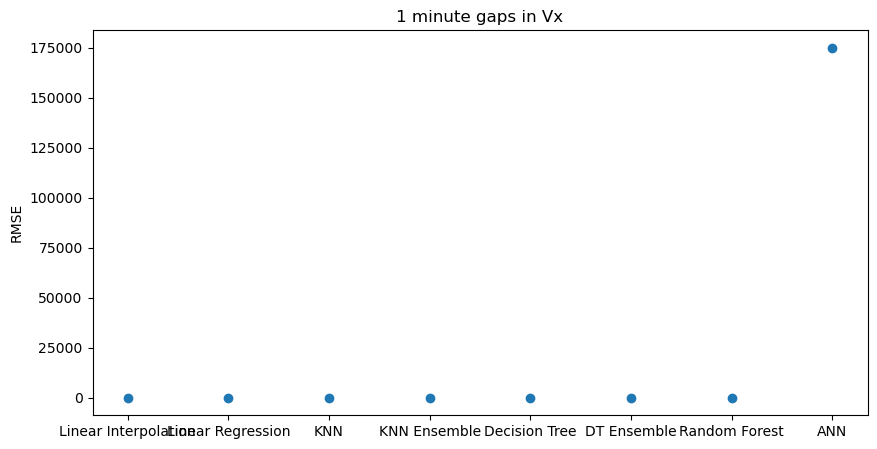

In [ ]:
fig = plt.figure(figsize=(10,5))
x = [i for i in range(len(error_list))]
x_labels = ['Linear Interpolation', 'Linear Regression', 'KNN', 'KNN Ensemble', 'Decision Tree', 'DT Ensemble', 'Random Forest', 'ANN']
plt.scatter(x, error_list)
plt.xticks(x, x_labels)
plt.ylabel('RMSE')
plt.title('1 minute gaps in Vx')
plt.show()

In [ ]:
print(error_list)

[4.351140004307842, 55.47773508953248, 64.5505261427038, 63.61760945049901, 1.6100637416343677, 1.5407711452735762, 0.8342372107619912, 175026.61586315656]


In [ ]:
testing_data

,B_Total,BY_GSM,BZ_GSM,Vx,Vy,Vz,proton_density,T,Pressure,E_Field
ACEepoch,,,,,,,,,,
1998-02-05 00:02:00,-0.093000,-1.552128,3.600013,324.736481,-3.829421,6.870095,15.441054,8463.191406,3.256635,-1.169055
1998-02-05 00:04:00,-0.054967,-1.649037,3.725267,324.035065,-2.356790,5.402121,15.275183,8814.488281,3.207749,-1.207117
1998-02-05 00:12:00,-0.046733,-0.980301,2.238769,325.348480,-1.361589,3.117557,15.345948,9719.403320,3.248787,-0.728380
1998-02-05 00:20:00,0.047567,-1.057289,2.191027,325.238068,-2.426035,5.355429,14.230998,9736.037109,3.010704,-0.712605
1998-02-05 00:24:00,0.212267,-1.344382,2.434786,324.817078,-2.140779,4.128282,15.095506,10560.573242,3.185337,-0.790860
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:43:00,1.086425,-1.455036,2.464253,367.367767,7.244548,-6.524168,4.175431,17136.294922,1.127025,-0.905287
2020-12-31 23:45:00,1.712325,-2.000533,1.867796,364.496674,9.827152,-9.266292,4.544740,20005.916016,1.207608,-0.680805
2020-12-31 23:47:00,1.719525,-2.039018,2.086994,366.163208,2.395710,-8.083668,4.325659,18338.634766,1.159930,-0.764180


In [ ]:
param = 'T'

error_df = pd.DataFrame()
error_df['real'] = testing_data[param]
error_df['linear_interp'] = y_true - test_vx['linear_interp']
error_df['linear_regression'] = y_true - test_vx['linear_regression']
error_df['knn'] = y_true - test_vx['knn']
error_df['knn_ensamble'] = y_true - test_vx['knn_ensamble']
error_df['tree'] = y_true - test_vx['tree']
error_df['tree_ensamble'] = y_true - test_vx['tree_ensamble']
error_df['forest'] = y_true - test_vx['forest']


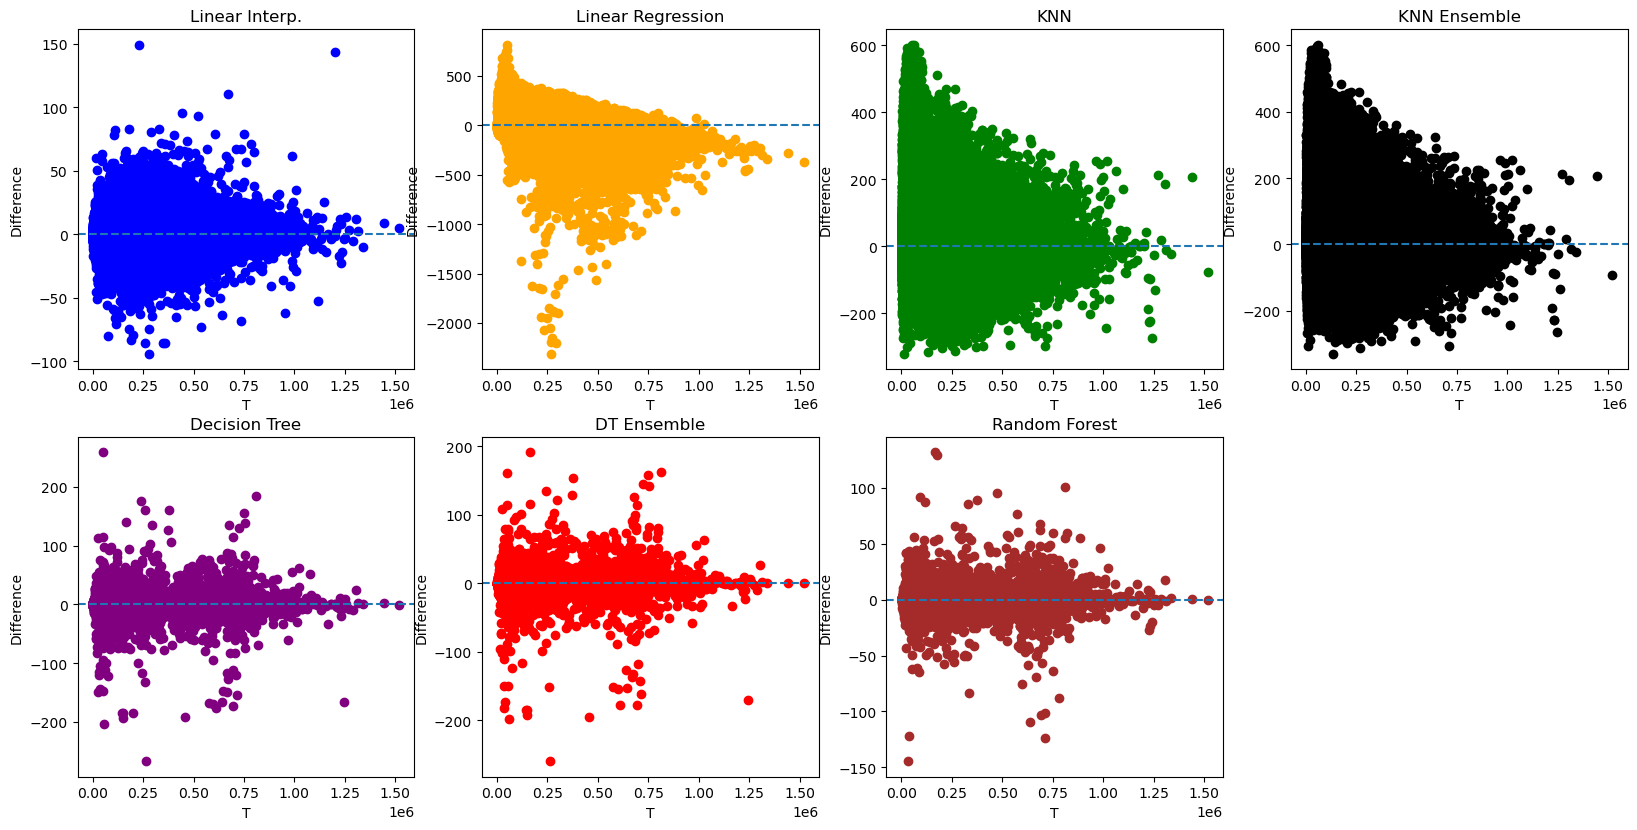

In [ ]:
fig = plt.figure(figsize=(20,15))

ax0 = plt.subplot(341)
plt.scatter(error_df['real'], error_df['linear_interp'], color='blue')
plt.title('Linear Interp.')
plt.axhline(0, linestyle='--')
plt.ylabel('Difference')
plt.xlabel(param)

ax1 = plt.subplot(342)
plt.scatter(error_df['real'], error_df['linear_regression'], color='orange')
plt.title('Linear Regression')
plt.axhline(0, linestyle='--')
plt.ylabel('Difference')
plt.xlabel(param)

ax2 = plt.subplot(343)
plt.scatter(error_df['real'], error_df['knn'], color='green')
plt.title('KNN')
plt.axhline(0, linestyle='--')
plt.ylabel('Difference')
plt.xlabel(param)

ax3 = plt.subplot(344)
plt.scatter(error_df['real'], error_df['knn_ensamble'], color='black')
plt.title('KNN Ensemble')
plt.axhline(0, linestyle='--')
plt.ylabel('Difference')
plt.xlabel(param)

ax4 = plt.subplot(345)
plt.scatter(error_df['real'], error_df['tree'], color='purple')
plt.title('Decision Tree')
plt.axhline(0, linestyle='--')
plt.ylabel('Difference')
plt.xlabel(param)

ax5 = plt.subplot(346)
plt.scatter(error_df['real'], error_df['tree_ensamble'], color='red')
plt.title('DT Ensemble')
plt.axhline(0, linestyle='--')
plt.ylabel('Difference')
plt.xlabel(param)

ax6 = plt.subplot(347)
plt.scatter(error_df['real'], error_df['forest'], color='brown')
plt.title('Random Forest')
plt.axhline(0, linestyle='--')
plt.ylabel('Difference')
plt.xlabel(param)

plt.show()